## Regression Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydataset import data


##### 1. Select a dataset with a continuous target variable.
- I'll use the 'swiss' dataset from pydataset and use the regression modeling techniques to predict fertility rates.
- This is a very small dataset so the split datasets will run into Central Limit Theorem limitations if the distribution is not normal.

In [16]:
data('swiss', show_doc=True)

swiss

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Swiss Fertility and Socioeconomic Indicators (1888) Data

### Description

Standardized fertility measure and socio-economic indicators for each of 47
French-speaking provinces of Switzerland at about 1888.

### Usage

    data(swiss)

### Format

A data frame with 47 observations on 6 variables, each of which is in percent,
i.e., in [0,100].

[,1] Fertility Ig, "common standardized fertility measure" [,2] Agriculture
[,3] Examination nation [,4] Education [,5] Catholic [,6] Infant.Mortality
live births who live less than 1 year.

All variables but 'Fert' give proportions of the population.

### Source

Project "16P5", pages 549-551 in

Mosteller, F. and Tukey, J. W. (1977) “Data Analysis and Regression: A Second
Course in Statistics”. Addison-Wesley, Reading Mass.

indicating their source as "Data used by permission of Franice van de Walle.
Office of Population Research, Princeton Univer

###### Also found a better data dict at https://abhinavcreed13.github.io/blog/swiss-dataset-modelling-in-R/

[,1] Fertility - Ig, ‘common standardized fertility measure’

[,2] Agriculture - % of males involved in agriculture as occupation

[,3] Examination - % draftees receiving highest mark on army examination

[,4] Education - % education beyond primary school for draftees.

[,5] Catholic - % ‘catholic’ (as opposed to ‘protestant’).

[,6] Infant.Mortality - live births who live less than 1 year.

All variables but ‘Fertility’ give proportions of the population.



In [21]:
# put these descriptions into a dict:
data_dict = {'fertility':'common standardized fertility measure', 
             'agriculture':'% of males involved in agriculture as occupation',
            'examination':'% draftees receiving highest mark on army examination', 
             'education':'% education beyond primary school for draftees', 
             'catholic': "% ‘catholic’ (as opposed to ‘protestant’)", 
            'infant_mortality':'live births who live less than 1 year'}

In [2]:
swiss = data('swiss')
swiss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


##### 2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.



In [3]:
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


- okay, now to wrangle this data:
    - it appears there are no null values.
    - columns are all numeric and continuous
    - titles could use pythonic standardization
    - all columns need scaling in preprocessing

In [4]:
swiss.rename(columns = {'Fertility':'fertility', 
                        'Agriculture':'agriculture', 
                        'Examination':'examination', 
                        'Education':'education', 
                        'Catholic':'catholic', 
                        'Infant.Mortality':'infant_mortality'},
            inplace=True)
swiss.head()

,fertility,agriculture,examination,education,catholic,infant_mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [5]:
# do some quick univariate plots
cols = swiss.columns.tolist()
cols

['fertility',
 'agriculture',
 'examination',
 'education',
 'catholic',
 'infant_mortality']

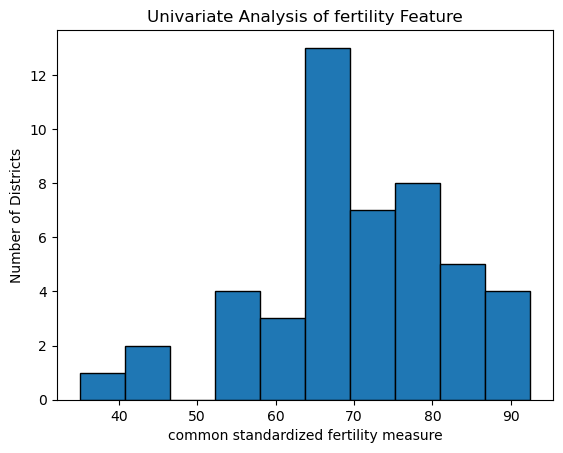

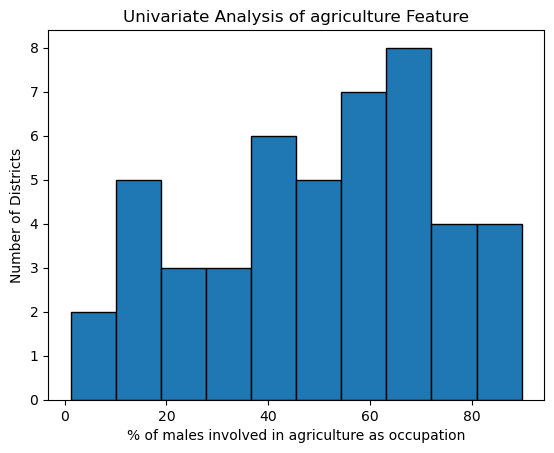

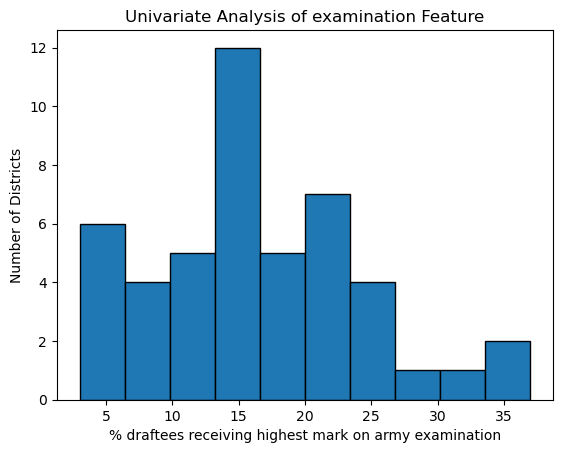

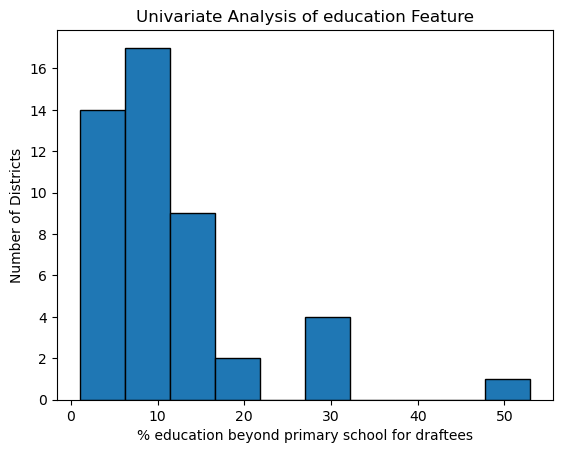

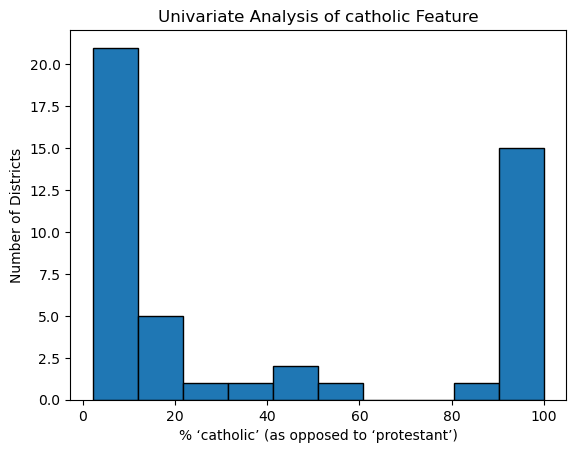

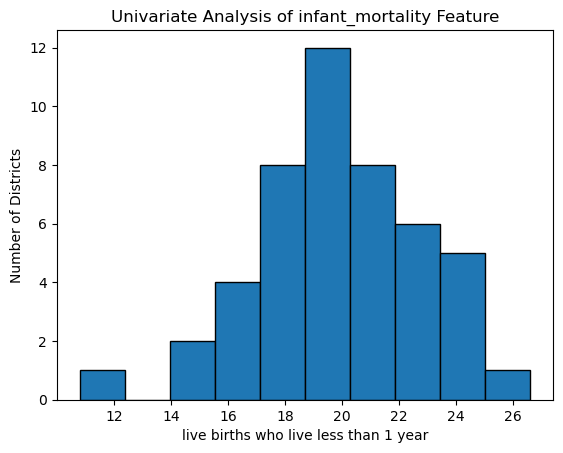

In [22]:
for col in cols:
    plt.hist(x=col, data=swiss, ec='black')
    plt.title(f'Univariate Analysis of {col} Feature')
    plt.ylabel('Number of Districts')
    plt.xlabel(f'{data_dict[col]}')
    plt.show()

**Takeaways from Univariate Analysis:**

- Target variable, infant_mortality, is relatively normally distributed.

- Fertility, Agriculture, Examination are not terribly far from normal.

- Education is strongly right skewed

- Catholic is strongly bimodal

##### 3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.



### EDA

##### For EDA, I will first split the data as there are no categorical variables to explore. I will wait to scale until ready to start modeling.

#### 1. Data Splitting:

In [23]:
from sklearn.model_selection import train_test_split

In [26]:
train_val, test = train_test_split(swiss, test_size=0.2, random_state=9751)
train, val = train_test_split(train_val, test_size=0.3, random_state=9751)
train.shape, val.shape, test.shape

((25, 6), (12, 6), (10, 6))

#### 2. Bivariate Visualization:

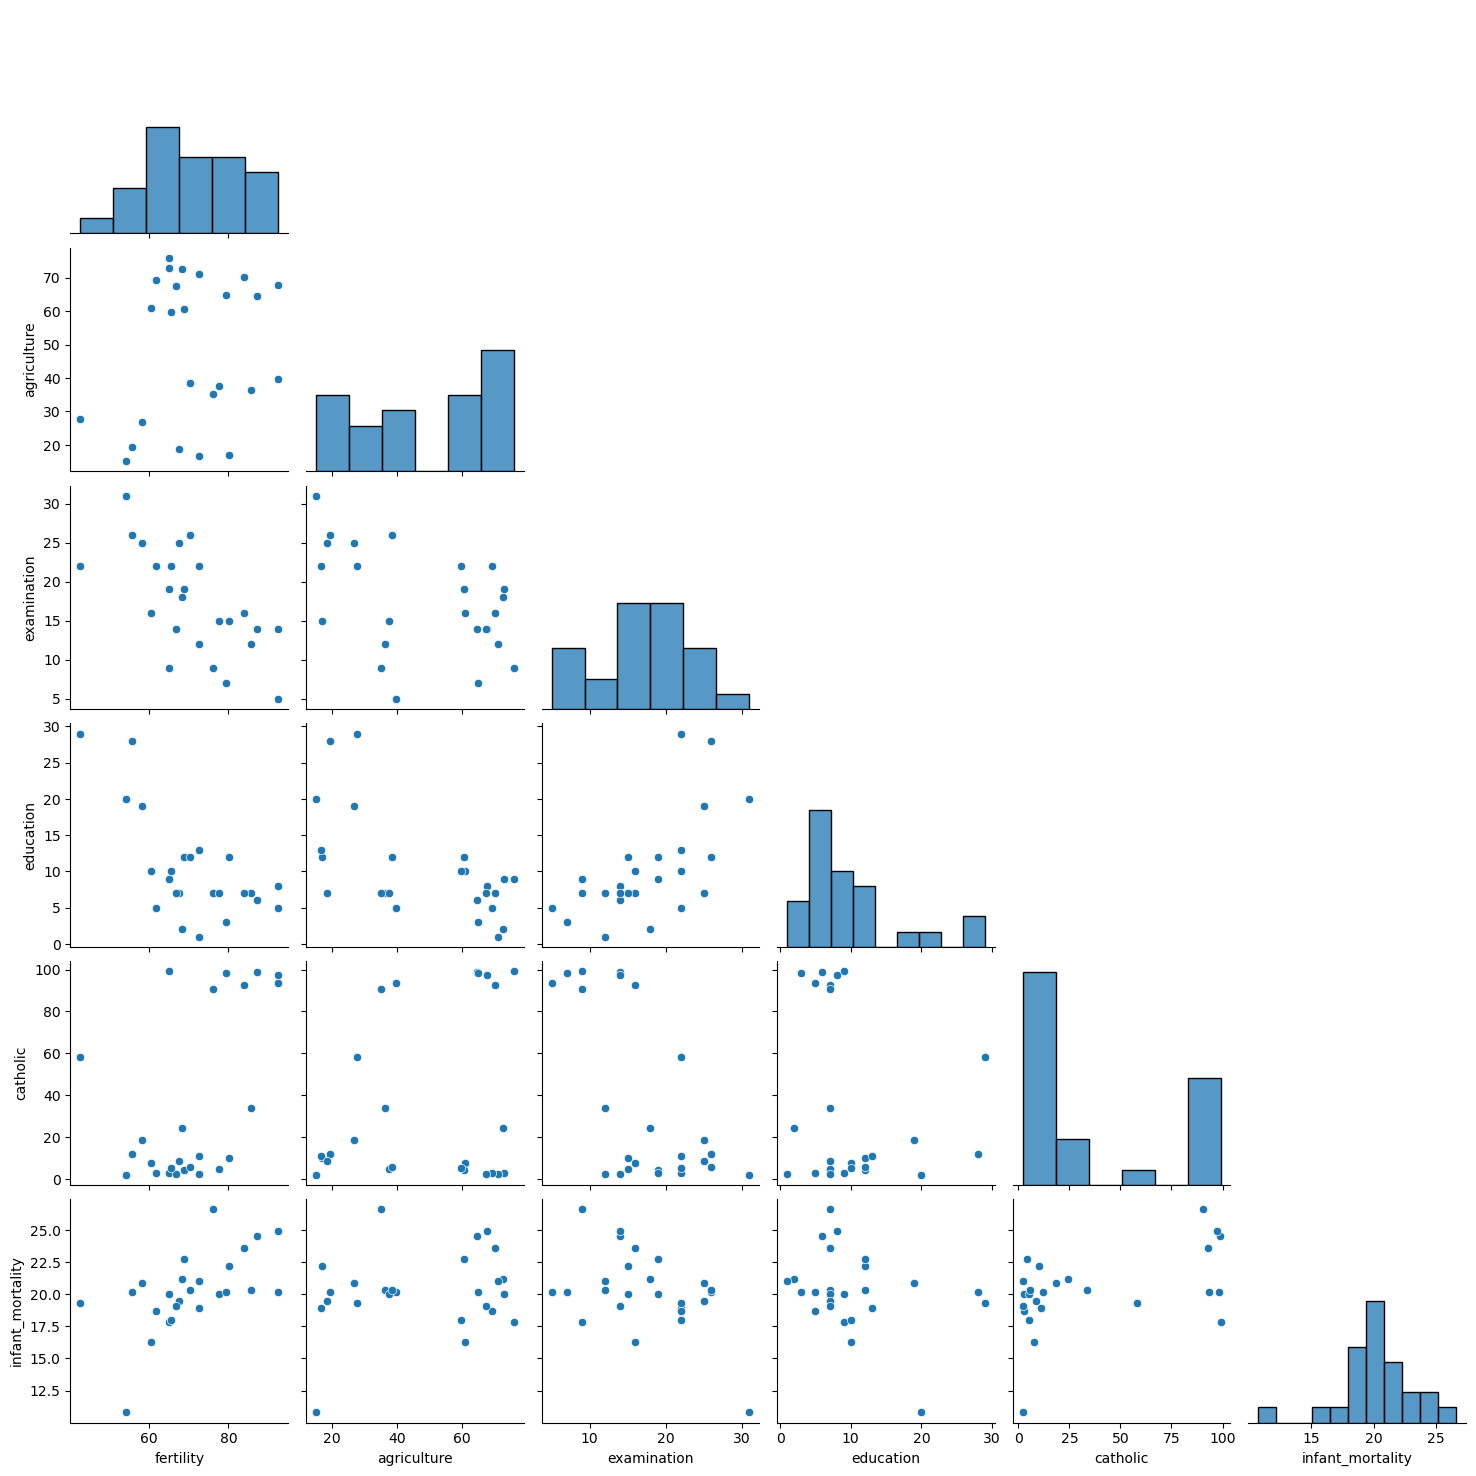

In [27]:
sns.pairplot(train, corner=True)
plt.show()

**Takeaways from Bivariate Vis:**
1. There appears to be some collinearity between education and examination, which may be expected. May choose to drop one of those features for modeling.
2. There appear to be an inverse correlation between fertility and education/examination
3. It appears that catholicism increases fertility and infant mortality, while decreasing examination and education.
4. Agriculture seems fairly neutral

In [33]:
# split data between features and target for exploration
X_train_exp = train.drop(columns='fertility')
y_train = train.fertility

#### 3. Hypothesis Testing:

1. Correlation between fertility and infant_mortality
2. Correlation between fertility and education
3. Correlation between fertility and examination
4. Correlation between fertility and catholic

$H_0:$ There is no positive linear correlation between fertility and infant mortality.

$H_a:$ There is a positive linear correlation between fertility and infant mortality.

In [46]:
from scipy.stats import pearsonr, spearmanr

In [31]:
# I will use a 95% confidence interval for all tests,
# so I will set alpha to 0.05
α = 0.05

In [50]:
X_cols = X_train_exp.columns.to_list()

# also going to divide into normally distributed and non-normal
not_norm_cols = ['catholic', 'education']

In [51]:
for col in X_cols:
    if col not in not_norm_cols:
        corr, p = pearsonr(X_train_exp[col], 
                             y_train)
        print(f'\n\n\nPearson correlation between {col} and fertility')
        print('_____________________________________________\n')
        print(f'The correlation coefficient is {corr}')
        if corr > 0:
            print(f'The correlation between {col} and fertility is positive')
        elif corr == 0:
            print(f'The correlation between {col} and fertility is zero')
        else:
            print(f'The correlation between {col} and fertility is negative')
        print(f'\nThe p-value is {p}')
        if p < α:
            print('We can reject the null hypothesis since p is less than alpha')
        else:
            print('We cannot reject the null hypothesis since p is greater than\
            \nor equal to than alpha')
    else:
        corr, p = spearmanr(X_train_exp[col], 
                             y_train)
        print(f'\n\n\nSpearman correlation between {col} and fertility')
        print('_____________________________________________\n')
        print(f'The correlation coefficient is {corr}')
        if corr > 0:
            print(f'The correlation between {col} and fertility is positive')
        elif corr == 0:
            print(f'The correlation between {col} and fertility is zero')
        else:
            print(f'The correlation between {col} and fertility is negative')
        print(f'\nThe p-value is {p}')
        if p < α:
            print('We can reject the null hypothesis since p is less than alpha')
        else:
            print('We cannot reject the null hypothesis since p is greater than\
            \nor equal to than alpha')




Pearson correlation between agriculture and fertility
_____________________________________________

The correlation coefficient is 0.21509865865965536
The correlation between agriculture and fertility is positive

The p-value is 0.30179952239755675
We cannot reject the null hypothesis since p is greater than            
or equal to than alpha



Pearson correlation between examination and fertility
_____________________________________________

The correlation coefficient is -0.6582874297491698
The correlation between examination and fertility is negative

The p-value is 0.00034726354767432267
We can reject the null hypothesis since p is less than alpha



Spearman correlation between education and fertility
_____________________________________________

The correlation coefficient is -0.5354966207001305
The correlation between education and fertility is negative

The p-value is 0.005804213487460735
We can reject the null hypothesis since p is less than alpha



Spearman correlatio

**Takeaways from Hypothesis Testing:**
- Hypothesis confirmed takeaways from visualization
    - Positive Correlations with Target ('fertility'):
        1. catholic
        2. infant_mortality
    - Negative Correlations with Target ('fertility'):
        1. examination
        2. education
    - No Correlation with Target ('fertility'):
        1. Agriculture

### Preprocessing for Modeling

In [55]:
# need to go ahead and split all datasets
X_train = train.drop(columns='fertility')
X_val = val.drop(columns='fertility')
X_test = test.drop(columns='fertility')
# y_train already established
y_val = val.fertility
y_test = test.fertility

In [52]:
# need to scale all features for modeling
# going to use MinMaxScaler as the target is normal
# and there are not too many outliers
from sklearn.preprocessing import MinMaxScaler

In [56]:
# make and fit the scaler on X_train_exp
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [64]:
# transform X_train, X_val, X_test
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [62]:
X_train_scaled.head()

,agriculture,examination,education,catholic,infant_mortality
0,0.945634,0.500000,0.035714,0.227531,0.658228
1,0.350906,0.269231,0.214286,0.326282,0.601266
2,0.029654,0.384615,0.392857,0.080590,0.721519
3,0.906096,0.423077,0.214286,0.935920,0.810127
4,0.403624,0.000000,0.142857,0.941595,0.594937


### Modeling

In [74]:
# we have scaled df's ready for modeling
# let's import modeling methods
# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures



- Since target is pretty normally distributed, I will use these models:
    1. Baseline
    2. OLS
    3. Lasso + Lars
    4. Tweedie Regressor
    5. Polynomial Regression  

<br>

- Model Evaluation Metrics:
    1. RMSE
    2. R2 (r-squared)

##### 1. Baseline

In [71]:
# I will use the mean for the baseline as the data is continuous
# so median is not useful.
# If we want to append y_preds from different models to y actuals,
# we need make y_train and y_val into DataFrames
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

y_train['baseline'] = y_train.fertility.mean()
y_val['baseline'] = y_train.fertility.mean()

y_train.head()

,fertility,fertility_pred_mean,baseline
Echallens,68.3,70.844,70.844
Moutier,85.8,70.844,70.844
Courtelary,80.2,70.844,70.844
Broye,83.8,70.844,70.844
Franches-Mnt,92.5,70.844,70.844


In [73]:
# Now find RMSE of baseline model
rmse_baseline_train = mean_squared_error(y_train.fertility, y_train.baseline) ** 0.5
rmse_baseline_val = mean_squared_error(y_val.fertility, y_val.baseline) ** 0.5

print(f"""RMSE using Mean
Train/In-Sample: {round(rmse_baseline_train, 2)} 
Validate/Out-of-Sample: {round(rmse_baseline_val, 2)}""")

RMSE using Mean
Train/In-Sample: 11.77 
Validate/Out-of-Sample: 10.3


#### Addendum/Note:

we will incrementally build a dataframe for comparison of our model performances

In [75]:
metric_df = pd.DataFrame(data=[{'model': 'mean_baseline', 
                                'RMSE_train': rmse_baseline_train, 
                               'RMSE_validate': rmse_baseline_val, 
                               'R2_validate': explained_variance_score(
                                   y_.fertility, y_val.baseline)}])

In [76]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,11.765892,10.301681,0.0


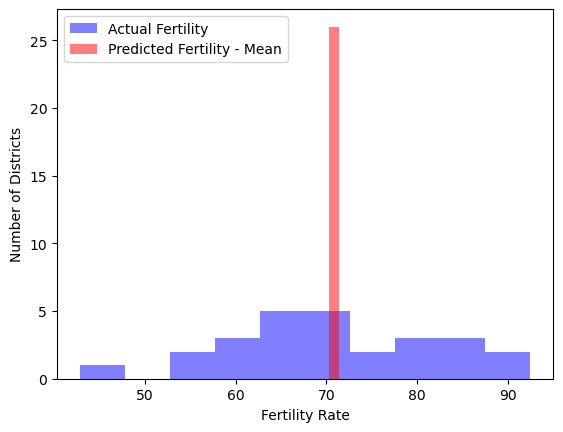

In [77]:
# # plot to visualize actual vs predicted. 

plt.hist(y_train.fertility, color='blue', alpha=.5, label="Actual Fertility")
plt.hist(y_train.baseline, bins=1, color='red', alpha=.5,  label="Predicted Fertility - Mean")
plt.xlabel("Fertility Rate")
plt.ylabel("Number of Districts")
plt.legend()
plt.show()

##### 2. Linear Regression (OLS)